In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.spatial import distance_matrix
from itertools import product, repeat

from functools import partial
from itertools import repeat

from metadata import Metadata
#from stkshow import stkshow
import multiprocessing
from collections import Counter

from scipy.spatial import KDTree

In [29]:
os.environ['MKL_NUM_THREADS'] = '16'
os.environ['GOTO_NUM_THREADS'] = '16'
os.environ['OMP_NUM_THREADS'] = '16'

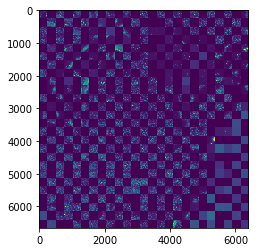

In [192]:
plt.imshow(stitched)

In [202]:
stkshow(stitched)

NameError: name 'stkshow' is not defined

In [111]:
from analysis_scripts.decon_codestacks import *
from seqfish_config_brain_tmi import *

In [201]:
codestacks = !find /scratch/freezerEtoh2weeks_controlTreatment_2018Sep08/ -type f

In [200]:
from analysis_scripts.hdata_iterative_classify_codestacks import *
from fish_results import *

In [102]:
posnames = !ls /scratch/freezerEtoh2weeks_controlTreatment_2018Sep08/


In [103]:
allhdatas = {p: HybeData(os.path.join('/scratch/freezerEtoh2weeks_controlTreatment_2018Sep08/', p)) for  
                        p in posnames}

In [194]:
posubset = np.random.choice(range(len(allhdatas)), size=20, replace=False)

hybedatas = [(allhdatas[p], p) for p in np.array(posnames)[posubset]]
#cur_nf = np.array(np.nanmean([mean_nfs(hdata, pos) for hdata, pos in hybedatas], axis=0))


In [195]:
combo = np.concatenate((norm_gene_codeword_vectors, norm_blank_codeword_vectors))
allids = np.array(gids+bids)

In [196]:
from analysis_scripts.parse_classification_images import *

In [211]:
classify_pfunc = partial(classify_file, nfactor=cur_nf, nvectors=combo, 
                        genesubset=np.arange(0, norm_gene_codeword_vectors.shape[0]))
parse_pfunc = partial(multi_z_class_parse_wrapper, cvectors=combo, genes=allids)
with multiprocessing.Pool(12) as ppool:
    ppool.starmap(classify_pfunc, hybedatas)
    dfs = ppool.starmap(parse_pfunc, hybedatas)
    df = pd.concat(dfs, ignore_index=True)
    errcount, bitfreq = find_bitwise_error_rate(df[df.gene.isin(gids)], norm_gene_codeword_vectors,
                            cur_nf)
    fnr = np.array([errocount[i]/bitfreq[i] for i in range(18)])
    fpcount = calc_fp(df[(df.gene.isin(bids)) & (df['mean']>500)], combo)
    fpr = fpcount/fpcount.mean()
    new_nf = cur_nf.copy()
    for i, fp in enumerate(fpcount):
        if fp/fpcount.mean()>1:
            new_nf[i] = cur_nf[i]*fp/fpcount.mean()
    update_nf = np.array(np.nanmean([mean_nfs(hdata, pos) for hdata, pos in hybedatas], axis=0))
    
    new_nf = [i if i>j else j for i, j in zip(new_nf, update_nf)]
    print(new_nf/cur_nf)
    cur_nf = new_nf

13-Pos_021_014
13-Pos_015_016
13-Pos_003_024
13-Pos_012_007
13-Pos_012_005
13-Pos_007_012
13-Pos_024_023
13-Pos_002_001
13-Pos_010_025
13-Pos_008_007
13-Pos_004_013
13-Pos_022_019
13-Pos_010_023
13-Pos_005_021
13-Pos_016_000
13-Pos_004_000
13-Pos_005_012
13-Pos_003_021
13-Pos_022_025
13-Pos_002_011


TypeError: only integer scalar arrays can be converted to a scalar index

In [209]:
update_nf/new_nf

array([0.63755616, 0.39128927, 0.66330002, 0.56931051, 0.6071601 ,
       0.51208905, 0.5186921 , 0.6328607 , 0.15282491, 0.26964801,
       0.34229181, 0.17060982, 0.35803802, 0.54168868, 0.20619326,
       0.31355798, 0.30024649, 0.41933352])

/home/rfor10/.conda/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


SpearmanrResult(correlation=-0.09436208427448865, pvalue=0.5785365165006275)

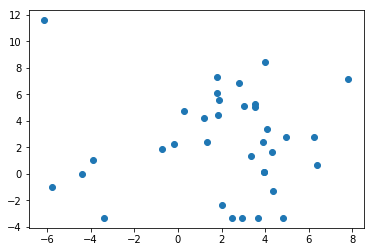

In [210]:
counts = Counter(df[(df.gene.isin(gids)) & (df['mean']>500)].gene)
    
expression = pd.read_excel('/home/rfor10/Downloads/ProbeCounts.xlsx')

vals = []
for gn, cc in counts.items():
    fpkm = expression[expression.Gene==gn]['TissueExpression (FPKM)'].values
    if len(fpkm)>0:
        vals.append((fpkm[0], cc))
fpkms, ccs = zip(*vals)
ccs = list(np.array(ccs)/(10))
from scipy.stats import spearmanr
plt.scatter(np.log2(fpkms), np.log2(ccs))
spearmanr(fpkms, ccs)

In [175]:
new_nf = np.array([i if i>j else j for i, j in zip(new_nf, update_nf)])
print(new_nf/cur_nf)
cur_nf = new_nf

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


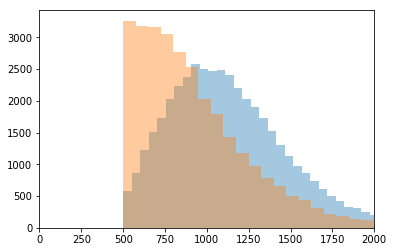

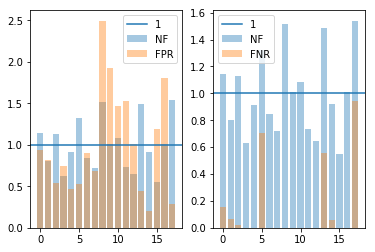

In [207]:
plt.hist(df[(df.gene.isin(gids)) & (df['mean']>500)]['mean'], bins=100, alpha=0.4)
plt.hist(df[df.gene.isin(bids) & (df['mean']>500)]['mean'], bins=50, alpha=0.4)
plt.xlim([0, 2000])
plt.show()

# errcount, bitfreq = find_bitwise_error_rate(df[(df.gene.isin(gids)) & (df['mean']>500)], norm_gene_codeword_vectors,
#                         cur_nf)
fnr = [errcount[i]/bitfreq[i] for i in range(18)]
# plt.bar(range(18), fnr, alpha=0.4)
plt.subplot(1,2,1)
plt.bar(range(18), cur_nf/np.mean(cur_nf), alpha=0.4)
plt.bar(range(18), fpr, alpha=0.4)

plt.axhline(y=1)
plt.legend(['1', 'NF', 'FPR'])
plt.subplot(1,2,2)
plt.bar(range(18), cur_nf/np.mean(cur_nf), alpha=0.4)
plt.bar(range(18), fnr, alpha=0.4)

plt.axhline(y=1)
plt.legend(['1', 'NF', 'FNR'])


In [151]:
ng_factor = norm_gene_codeword_vectors.shape[0]/norm_blank_codeword_vectors.shape[0]

In [172]:
fpr

array([1.36863334, 1.72102553, 0.54509762, 0.98245012, 0.15157691,
       0.58854323, 0.42615319, 0.64067797, 1.62158335, 0.72563828,
       0.79379961, 1.84286634, 1.08787814, 1.45996567, 1.01431023,
       1.32074662, 0.43928342, 1.26977044])

In [173]:
fp

6576

In [156]:
fnr

[0.43536683687180866,
 0.7844372206420155,
 0.017761989342806393,
 0.0,
 0.4440052700922266,
 0.7082810539523212,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0892175572519084,
 0.0,
 0.0,
 0.7465674550447338,
 0.0,
 0.0,
 0.0,
 0.23151082496580713]

1000
2000
3000
4000
6000
8000
14000
15000
17000
20000
27000
28000
30000
31000
32000
36000
38000
39000
40000
41000
42000
44000
46000
50000
53000
56000
58000
60000
62000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
78000
79000
80000
81000


In [138]:
update_nf

array([1399.00835876,  585.66468252, 2320.95382161, 1091.85462341,
       1611.2468689 , 1513.92139893, 1721.0926241 , 1460.64291687,
        584.52062785,  923.84599813, 1040.658284  ,  207.54827143,
        566.94981893, 1302.9284495 ,  243.9653717 ,  359.14049632,
        972.16268819, 1321.26554871])

In [132]:
update_nf/cur_nf

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.58487781, 0.74708519, 1.        , 0.60001776,
       0.38177466, 1.        , 1.        ])

In [130]:
fpcount/fpcount.mean()

array([2.08583618, 0.65919257, 0.88112243, 0.32443709, 0.03146262,
       1.36507161, 0.15612901, 0.32545202, 0.67187911, 0.66663534,
       0.94100289, 1.85714017, 1.84377702, 0.83274443, 1.71183701,
       2.58568582, 0.45671541, 0.60387926])

In [73]:
from collections import Counter
def calc_fp(fp_calls, cwords):
    gene_mean_intensity_thresh = 10**2.6
    bit_error_freq = Counter()
    true_fp = fp_calls[fp_calls['mean']>gene_mean_intensity_thresh]
    for idx, row in true_fp.iterrows():
        cidx = row.cword_idx
        cidx = np.where(cwords[cidx])[0]
        bit_error_freq.update(cidx)
    # blank_counts = Counter(.gene)
    # plt.hist(blank_counts.values(), bins=20)
    bitidx, fpcount = zip(*bit_error_freq.items())
    return np.array(fpcount)[np.argsort(bitidx)]

<BarContainer object of 18 artists>

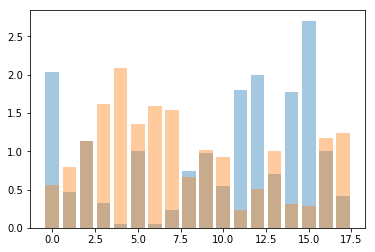

In [64]:
plt.bar(bitidx, fpcount/np.mean(fpcount), alpha=0.4)
plt.bar(range(18), cur_nf/cur_nf.mean(), alpha=0.4)

In [65]:
cur_nf

array([ 419.93567088,  591.81489639,  850.78053818, 1210.03229375,
       1562.95935437, 1014.7912114 , 1188.77698075, 1148.8311947 ,
        493.80728161,  759.37361602,  697.27619583,  173.83764623,
        382.02039523,  749.96193703,  231.95480766,  209.978578  ,
        877.12286032,  924.48634249])

In [53]:
df[df['mean']>500]

,gene,centroid,pixel_values,mean,npixels,cword_idx,coords
20,blank67,"(2.0, 865.0)","[466.4979553222656, 381.13531494140625, 346.60...",521.460808,1,104,"[[2, 865]]"
25,blank8,"(5.333333333333333, 911.3333333333334)","[851.0814208984375, 1011.6363525390625, 513.25...",637.687515,3,45,"[[5, 911], [5, 912], [6, 911]]"
31,blank29,"(8.0, 116.0)","[272.56829833984375, 1196.229248046875, 290.16...",521.782768,1,66,"[[8, 116]]"
56,Klf13,"(11.0, 862.0)","[154.68209838867188, 1036.0679931640625, 1228....",873.809044,1,16,"[[11, 862]]"
65,blank8,"(12.5, 1557.5)","[1762.2640380859375, 461.6721496582031, 1306.4...",895.393517,4,45,"[[12, 1557], [12, 1558], [13, 1557], [13, 1558]]"
87,blank29,"(17.666666666666668, 1698.3333333333333)","[700.4004516601562, 1996.4356689453125, 361.10...",958.521932,3,66,"[[17, 1698], [18, 1698], [18, 1699]]"
109,blank134,"(21.0, 1977.0)","[762.3342895507812, 567.1077270507812, 484.160...",511.892212,1,171,"[[21, 1977]]"
135,blank21,"(26.5, 262.5)","[1120.388916015625, 974.736083984375, 805.1629...",887.996452,4,58,"[[26, 262], [26, 263], [27, 262], [27, 263]]"
152,Nt5dc3,"(28.666666666666668, 1774.3333333333333)","[818.2233276367188, 895.1804809570312, 735.653...",1325.143478,3,21,"[[28, 1774], [29, 1774], [29, 1775]]"
159,blank105,"(29.8, 1592.2)","[1341.131591796875, 335.841796875, 230.9104309...",608.982891,5,142,"[[29, 1591], [29, 1592], [30, 1592], [30, 1593..."


In [52]:
fp['mean'].mean()

504.1124658183416

(0, 1500)

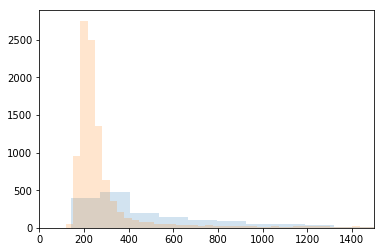

In [51]:
plt.hist(fp['mean'], alpha=0.2, bins=20)
plt.hist(df['mean'], alpha=0.2, bins=100)
plt.xlim([0, 1500])

In [47]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:


def find_bitwise_neg_error_rate(df, cvectors, norm_factor):
    cvectors = cvectors.copy()
    np.place(cvectors, cvectors>0., 1.)
    error_counts = Counter()
    bit_freq = Counter()
    for idx, row in df.iterrows():
        if idx % 1000 == 0:
            print(idx)
        cword = cvectors[row.cword_idx]
        cidx = np.where(cword==1.)[0]
        cnf = norm_factor[cidx]#/1.5
        bit_freq.update(cidx)
        bmeans = np.mean(row.pixel_values, axis=0)
        norm_bmeans = np.divide(bmeans, cnf)
        dists = distance_matrix(norm_bmeans[np.newaxis, :], [[1, 1, 1, 1],
                                                 [0, 1, 1, 1], 
                                                 [1, 0, 1, 1],
                                                 [1, 1, 0, 1],
                                                 [1, 1, 1, 0]])
        min_dist = np.argmin(dists)
        if min_dist == 0:
            continue
        else:
            berror = cidx[min_dist-1]
            error_counts[berror]+=1
        #print(berror)
        #break
    return error_counts, bit_freq

In [11]:
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['GOTO_NUM_THREADS'] = '4'
os.environ['OMP_NUM_THREADS'] = '4'
print(args)
# Assuming these get imported during call below:
# 1. bitmap
# 2. bids, blanks, gids, cwords, gene_codeword_vectors, blank_codeword_vectors
# 3. norm_gene_codeword_vectors, norm_blank_codeword_vectors
#     cstk_path = args.cstk_path
#     ncpu = args.ncpu
#     niter = args.niter




# Note preceding blocks and this can be noisy if restarted after crash etccc
# Note preceding blocks and this can be noisy if restarted after crash etccc
with multiprocessing.Pool(ncpu) as ppool:
    failed_positions = []
    for i in range(niter):
        print('N Positions left: ', len(hybedatas))
        if i == 0:
            cur_nf = np.array(np.nanmean([mean_nfs(hdata, pos) for pos, hdata in hybedatas], axis=0))
            print('90th Percentile Normalization factors:', cur_nf, sep='\n')
        else:
            cur_nf = np.array(np.nanmean([mean_nfs(hdata, pos) for pos, hdata in hybedatas], axis=0))
            cur_nf = np.array([10**2.6 if (i<10**2.6) or np.isnan(i) else i for i in cur_nf])
            print(cur_nf)
        classify_pfunc = partial(classify_file, nfactor=cur_nf, nvectors=normalized_gene_vectors)
        results = ppool.starmap(classify_pfunc, [(i[1], i[0]) for i in hybedatas])


In [12]:
p_to_do = np.random.choice(list(hybedatas.keys()), size=4, replace=False)

In [13]:
from collections import defaultdict

In [14]:
cstk.shape

NameError: name 'cstk' is not defined

In [15]:
bit_vals = defaultdict(list)
pos_data = {}
npdone = 0
for p in p_to_do:
    hdata = hybedatas[p]
    print(p)
    for z in [8]:#hdata.metadata.zindex.unique():
        cstk = hdata.load_data(p, z, 'cstk')
        break
        all_data = []
        for i in range(cstk.shape[2]):
            img = cstk[:,:,i]
            peaks = peak_local_max(img, threshold_abs = 650,
                                   indices=True)
            vals = np.array([img[x, y] for x, y in peaks])
            c = np.repeat(i, len(vals))
            data = np.concatenate((peaks, c[:, np.newaxis],
                                   vals[:, np.newaxis]), axis=1)
            all_data.append(data)
        all_data = np.concatenate(all_data, axis=0)
    pos_data[p] = all_data
    break
    
#             print(z, sum(peaks.flatten()))
#             vals = cstk[:,:,i][peaks]
#             bit_vals[i]+=list(vals)

#         break
#     break
#     npdone+=1
#     if np>5:
#         break

13-Pos_000_025


NameError: name 'all_data' is not defined

In [21]:
import pandas as pd
from skimage import feature
import time
from sklearn.cluster import DBSCAN
class FishSpotClusters(object):
    def __init__(self, registered_stk, posname, zindex):
                 #chromatic_dict = './chromatic_offsets_dict.pkl'):
        self._stk = registered_stk
        self._posname = posname
        self._zidx = zindex
        self._nc = self._stk.shape[2]
        self.norm_stk = self.normalize_codestack(stk=self._stk)
        #self._chromatic_dict = pickle.load(open(chromatic_dict, 'r'))
        self.bitmap = [('RS0095_cy5', 'hybe2', 'FarRed'), ('RS0109_cy5', 'hybe4', 'FarRed'),
          ('RS0175_cy5', 'hybe6', 'FarRed'), ('RS0237_cy5', 'hybe1', 'FarRed'),
          ('RS0307_cy5', 'hybe3', 'FarRed'), ('RS0332_cy5', 'hybe5', 'FarRed'),
          ('RS0384_atto565', 'hybe5', 'Orange'), ('RS0406_atto565', 'hybe6', 'Orange'),
          ('RS0451_atto565', 'hybe4', 'Orange'), ('RS0468_atto565', 'hybe3', 'Orange'),
          ('RS0548_atto565', 'hybe2', 'Orange'), ('RS64.0_atto565', 'hybe1', 'Orange'),
          ('RSN9927.0_cy5', 'hybe8', 'FarRed'), ('RSN2336.0_cy5', 'hybe7', 'FarRed'), 
          ('RSN1807.0_cy5', 'hybe9', 'FarRed'), ('RSN4287.0_atto565', 'hybe7', 'Orange'), 
          ('RSN1252.0_atto565', 'hybe9', 'Orange'), ('RSN9535.0_atto565', 'hybe8', 'Orange')
         ]
    
    def normalize_codestack(self, stk=None, samp_size = 10**5, verbose = False):
        """
        Attempt to equalize the intensity of spots between channels and hybes.
        """
        if stk is None:
            stk = self._stkm
        norm_stk = np.copy(stk).astype(np.float32)
        for i in range(stk.shape[2]):
            background = np.random.choice(stk[:,:,i].flatten(), size=samp_size)
            bg_mean = np.percentile(background, 50)
            bg_std = np.std(background)
            norm_stk[:,:,i] = (norm_stk[:,:,i]-bg_mean)/bg_std
            if verbose:
                print('Mean and standard Deviation of background sample: ',
                      bg_mean, '-', bg_std)
        return norm_stk
    
    def find_corrected_peaks(self, nstk, zindex, min_thresh=2.):
        """
        Images are affected by apparent chromatic abberation so apply the fitted warping 
        to coordinates identified as regional maxima in the images.
        """
        df_reg_max = pd.DataFrame(columns=['yx', 'c', 'z', 'val'])
        for i in range(nstk.shape[2]):
            peaks = feature.peak_local_max(nstk[:,:,i], threshold_abs=min_thresh)
            peaks_corrected = peaks
            #peaks_corrected = self._apply_chromatic_abberation_correction(peaks, self._bitmap[i][2])
            intensities = [nstk[x, y, i] for x, y in peaks]
            new_data = pd.DataFrame.from_dict({'yx': list(peaks_corrected), 'c': np.repeat(i, len(peaks_corrected)),
                        'z': np.repeat(zindex, len(peaks_corrected)), 'val': np.array(intensities)})
            df_reg_max = df_reg_max.append(new_data, ignore_index=True)
        return df_reg_max

    def _apply_chromatic_abberation_correction(self, YX, channel):
        chromatic_dict = self._chromatic_dict
        new_coords = []
        for coords in YX:
            if channel == 'Orange':
                new_coords.append(coords)
                continue
            if channel == 'Green':
                p_x = chromatic_dict['dx_model_oMgreen']
                p_y = chromatic_dict['dy_model_oMgreen']
                offset = (np.polyval(p_y, coords[0]), np.polyval(p_x, coords[1]))
            if channel == 'FarRed':
                p_x = chromatic_dict['dx_model_oMfarred']
                p_y = chromatic_dict['dy_model_oMfarred']
                offset = (np.polyval(p_y, coords[0]), np.polyval(p_x, coords[1]))
            new_coords.append((coords[0]+offset[0], coords[1]+offset[1]))
        return np.array(new_coords)
    
    def cluster_and_filter_clusters(self, maxie_df, z, d=2, min_samples = 3.,
                                    num_cores=1, verbose = False):
        """
        Regional maxima are grouped together by a density clustering method.
        """
        maxies_yx = [i for i in maxie_df['yx'].values]
        t = time.time()
        # Density clustering
        clusters = DBSCAN(eps=d, min_samples = min_samples, metric='euclidean',
                          leaf_size=20, n_jobs=num_cores)
        clusters.fit(maxies_yx)
        cluster_dict = defaultdict(list)
        print('Finished DBScan: ', time.time()-t)
        not_clustered = 0
        # Remove regional maxima that were not in any clusters
        for data_idx, j in enumerate(clusters.labels_):
            if j==-1:
                not_clustered+=1
            else:
                cluster_dict[j].append(data_idx)
        cid, data_idx = zip(*cluster_dict.items())
        r = len(cid) # Number clusters
        print('Finished building lookup table: ', time.time()-t)
        coords = []
        trajs = []
        count5plus = 0
        countGood = 0
        coords_5plus = []
        trajs_5plus = []
        for locations in data_idx:
            if len(locations)<=5:
                candidate_coords = [maxies_yx[ii] for ii in locations]
                cidx = [maxie_df.iloc[j]['c'] for j in locations]
                candidate_coords = [(candidate_coords[j][0], candidate_coords[j][1],
                                     cidx[j]) for j in range(len(locations))]
                candidate_intensities = [maxie_df.iloc[j]['val'] for j in locations]
                coords.append(zip(candidate_coords, candidate_intensities))
                trajs.append(zip([i[2] for i in candidate_coords], candidate_intensities))
                countGood+=1
            else:
                count5plus += 1
                candidate_coords = [maxies_yx[ii] for ii in locations]
                cidx = [maxie_df.iloc[j]['c'] for j in locations]
                candidate_coords = [(candidate_coords[j][0], candidate_coords[j][1],
                                     cidx[j]) for j in range(len(locations))]
                candidate_intensities = [maxie_df.iloc[j]['val'] for j in locations]
                coords_5plus.append(zip(candidate_coords, candidate_intensities))
                trajs_5plus.append(zip([i[2] for i in candidate_coords], candidate_intensities))
        coords = [i for i in coords if i!=None]
        trajs = [i for i in trajs if i!=None]
        coords_5plus = [i for i in coords if i!=None]
        trajs_5plus = [i for i in trajs if i!=None]
        
        df = self._dataframe_from_clusters(zip(coords, trajs), z)
#         if len(coords_5plus)>1:
#             df_5plus = self._dataframe_from_clusters(zip(coords_5plus, trajs_5plus), z)
#         else:
#             df_5plus = []
        if verbose:
            print('Finished annotating clusters: ', time.time()-t)
            print('Good candidate: ', countGood)
            print('Bad candidate: ', count5plus)
            print('Not clustered: ', not_clustered)
        return df
    
    def _dataframe_from_clusters(self, clusters, zindex):
        x = []
        y = []
        codebits = []
        z_list = []
        vals = []
        centroids = []
        yx_list = []
        clusters_dict = {zindex: clusters}
        for z, clusts in clusters_dict.items():
            for c in clusts:
                yxc_val, traj = c[0], c[1]
                yxc, val = zip(*yxc_val)
                yx = [i[:2] for i in yxc]
                c = [i[2] for i in yxc]
                yx_list.append(yx)
                codebits.append(c)
                z_list.append(z)
                vals.append(val)
                centroid = self._centeroidnp(np.array(yx))
                centroids.append(centroid)
        df = pd.DataFrame.from_dict({'yx': yx_list, 'c': codebits,
                                     'vals': vals, 'z': z_list, 'centroid': centroids})
        return df
    
    def _centeroidnp(self, arr):
        length = arr.shape[0]
        sum_x = np.sum(arr[:, 0])
        sum_y = np.sum(arr[:, 1])
        return sum_x/length, sum_y/length
    def save_data(self, data_dict, fname):
        with open(fname, 'w') as f:
            pickle.dump(data_dict, f)
        
        

In [ ]:
plt.hist(spots._stk[:,:,0].flatten())

In [22]:
spots = FishSpotClusters(cstk, p, 8)

In [23]:
peak_df = spots.find_corrected_peaks(spots.norm_stk, 8)

In [ ]:
print('hi')

In [20]:
%pdb

Automatic pdb calling has been turned ON


In [25]:
df = spots.cluster_and_filter_clusters(peak_df, 8, num_cores=8)

Finished DBScan:  14.655190229415894
Finished building lookup table:  15.66088342666626


In [26]:
df

,yx,c,vals,z,centroid
0,"[(2046, 1190), (2046, 1193), (2046, 1192)]","[0, 4, 12]","(2.0695512, 2.116349, 3.3372815)",8,"(2046.0, 1191.6666666666667)"
1,"[(2046, 984), (2046, 983), (2046, 983), (2045,...","[0, 3, 4, 10, 16]","(2.319652, 2.3280604, 3.376749, 2.473247, 3.31...",8,"(2045.8, 983.8)"
2,"[(2046, 958), (2046, 960), (2046, 961)]","[0, 1, 3]","(2.6112807, 2.0425632, 3.4818826)",8,"(2046.0, 959.6666666666666)"
3,"[(2046, 653), (2046, 651), (2046, 649), (2045,...","[0, 1, 2, 2, 14]","(2.2371097, 2.2120636, 2.3366394, 2.3314288, 2...",8,"(2045.6, 651.0)"
4,"[(2045, 1063), (2045, 1067), (2045, 1065), (20...","[0, 3, 8, 16, 17]","(2.678473, 2.6236885, 2.3620257, 2.9292147, 2....",8,"(2044.6, 1064.6)"
5,"[(2045, 1001), (2046, 1000), (2045, 999), (204...","[0, 3, 8, 12]","(2.3322241, 2.4841754, 2.7781081, 2.028471)",8,"(2045.25, 999.75)"
6,"[(2045, 536), (2045, 537), (2045, 539), (2046,...","[0, 3, 4, 8]","(2.1031954, 2.385034, 4.301753, 2.9914355)",8,"(2045.25, 537.5)"
7,"[(2045, 350), (2045, 353), (2046, 351), (2046,...","[0, 11, 13, 16]","(2.2935789, 2.210163, 2.2342148, 2.1127884)",8,"(2045.5, 351.75)"
8,"[(2044, 1493), (2046, 1491), (2044, 1493), (20...","[0, 3, 14, 15]","(2.7280602, 3.4161947, 2.0034335, 2.0757725)",8,"(2044.75, 1492.25)"
9,"[(2044, 1362), (2042, 1362), (2040, 1362), (20...","[0, 10, 11, 12, 16]","(2.4977696, 2.0876572, 2.5877233, 2.6158206, 2...",8,"(2041.6, 1362.4)"


In [ ]:
df, df5plus = spots.cluster_and_filter_clusters(peak_df, 8, num_cores=8)

Finished DBScan:  5.379206657409668
Finished building lookup table:  5.841710567474365


ValueError: not enough values to unpack (expected 2, got 0)

> <ipython-input-36-3ca3ea1da9bb>(153)_dataframe_from_clusters()
    151             for c in clusts:
    152                 yxc_val, traj = c[0], c[1]
--> 153                 yxc, val = zip(*yxc_val)
    154                 yx = [i[:2] for i in yxc]
    155                 c = [i[2] for i in yxc]



In [20]:
%pdb

Automatic pdb calling has been turned ON


In [31]:
import time

In [345]:
dbclust = DBSCAN(eps=2, min_samples=3)

In [346]:
dbclust.fit(all_data[:, :2])

DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=1, p=None)

In [350]:
Counter(dbclust.labels_).most_common()

[(-1, 3221),
 (327, 43),
 (323, 40),
 (520, 18),
 (28, 17),
 (337, 17),
 (1222, 17),
 (210, 16),
 (127, 14),
 (142, 14),
 (263, 14),
 (435, 14),
 (884, 14),
 (954, 14),
 (960, 14),
 (1036, 14),
 (1206, 14),
 (404, 13),
 (1188, 13),
 (50, 12),
 (54, 12),
 (175, 12),
 (318, 12),
 (409, 12),
 (795, 12),
 (869, 12),
 (1559, 12),
 (63, 11),
 (101, 11),
 (511, 11),
 (591, 11),
 (598, 11),
 (920, 11),
 (1019, 11),
 (1109, 11),
 (16, 10),
 (57, 10),
 (58, 10),
 (72, 10),
 (1163, 10),
 (331, 10),
 (369, 10),
 (390, 10),
 (446, 10),
 (473, 10),
 (483, 10),
 (529, 10),
 (572, 10),
 (747, 10),
 (783, 10),
 (996, 10),
 (1175, 10),
 (1216, 10),
 (1499, 10),
 (1673, 10),
 (73, 9),
 (177, 9),
 (193, 9),
 (229, 9),
 (240, 9),
 (302, 9),
 (307, 9),
 (358, 9),
 (371, 9),
 (407, 9),
 (412, 9),
 (470, 9),
 (518, 9),
 (642, 9),
 (653, 9),
 (1157, 9),
 (691, 9),
 (703, 9),
 (733, 9),
 (758, 9),
 (773, 9),
 (845, 9),
 (900, 9),
 (992, 9),
 (1079, 9),
 (1116, 9),
 (1143, 9),
 (1189, 9),
 (1403, 9),
 (1584, 9),

In [348]:
dbclust.labels_

2347

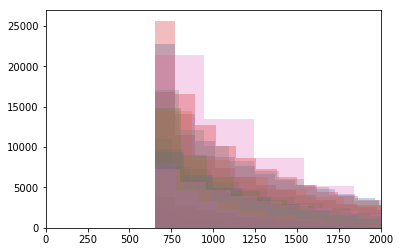

In [316]:
for i in range(len(bit_vals)):
    plt.hist(bit_vals[i], bins=100, alpha=0.3)
    plt.xlim([0, 2000])

In [257]:
bit_vals.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [249]:
vals.shape

(335301,)

In [254]:
bit_vals[0]

[]

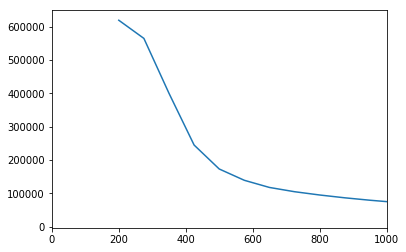

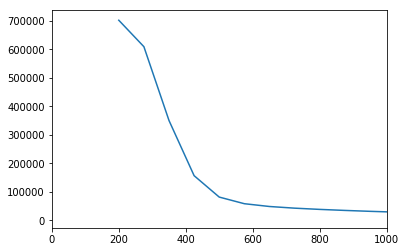

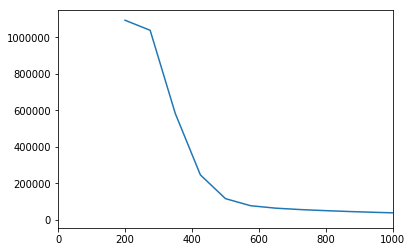

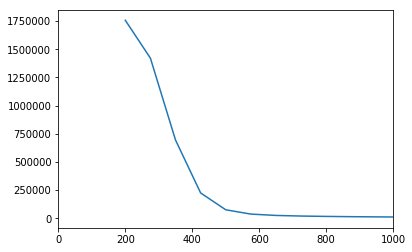

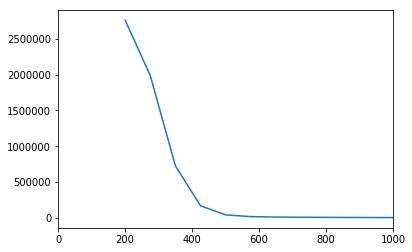

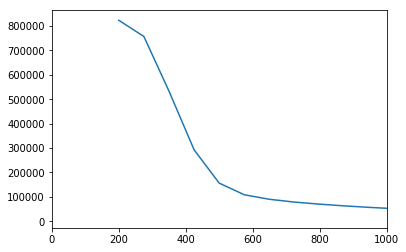

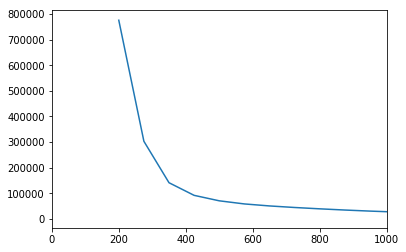

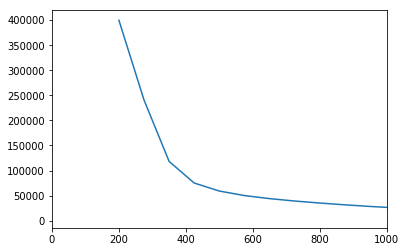

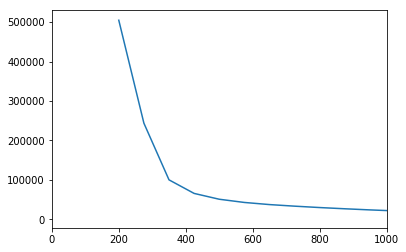

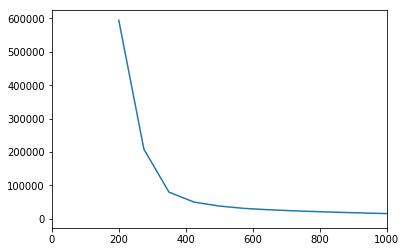

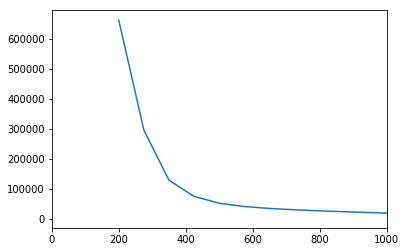

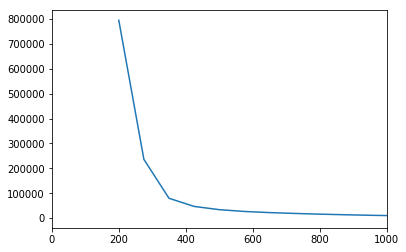

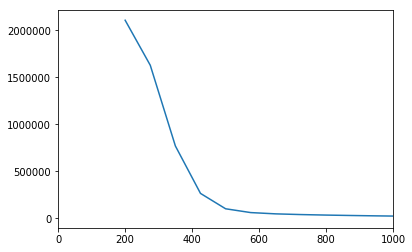

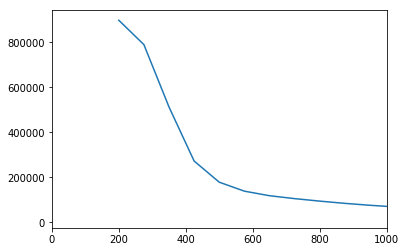

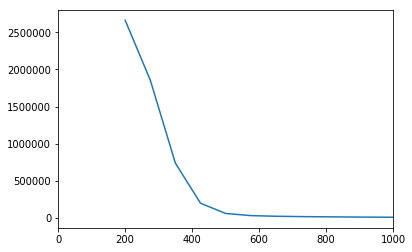

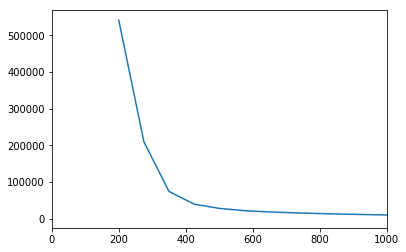

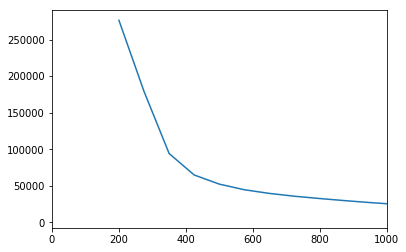

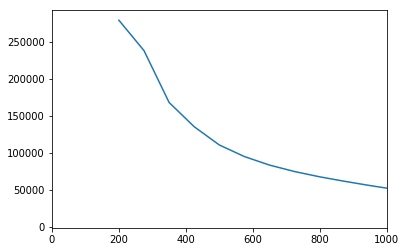

In [313]:
for i in range(len(bit_vals)):
    threshs = np.linspace(200, 2000, 25)
    n = []
    for t in threshs:
        ngreater = sum(bit_vals[i]>t)
        n.append(ngreater)
    plt.plot(threshs, n)
    plt.xlim([0, 1000])
    plt.show()

(0, 1000)

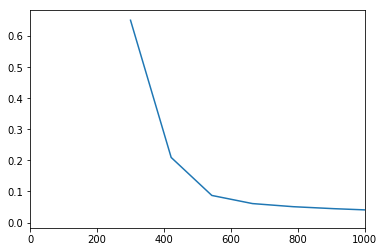

In [282]:
plt.plot(threshs, np.array(n)/len(bit_vals[0]))
plt.xlim([0, 1000])
# plt.ylim([0, 0.1])